In [2]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
import os
import h5py
import numpy as np
import time
import pandas as pd

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
#from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv
from collections import Counter
import itertools
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
import io

In [4]:
# tf.debugging.set_log_device_placement(True)

In [5]:
tf.__version__

'2.1.0'

In [6]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 854010119928201888
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9295179817879604939
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12642439625177305843
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1044657883085851675
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
]


In [7]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [39]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [40]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [41]:
projections = np.array(data['Projections'])
projections.shape

(5000, 116, 116)

In [42]:
np.save("data/5j0n/projections_5j0n_2.0,0.4,2.0.npy", projections)

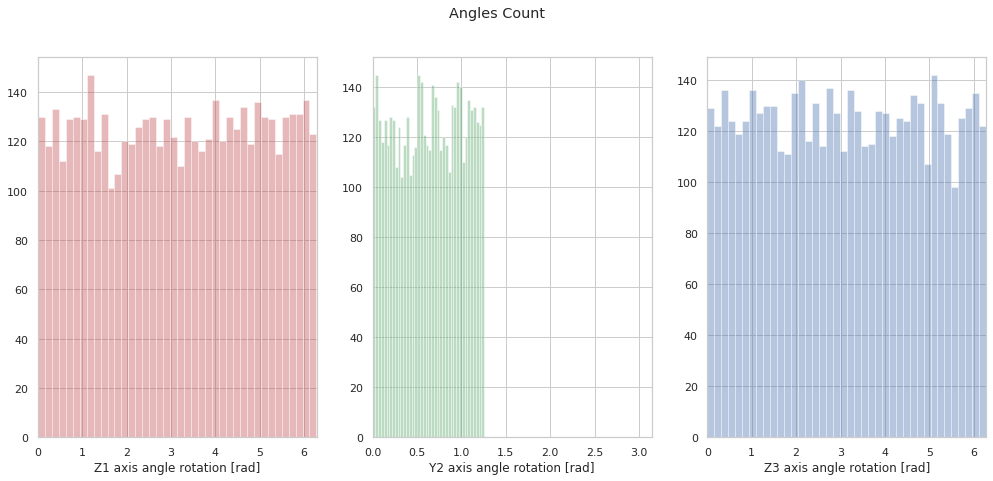

In [10]:
plot_angles_count(angles_true)

---

## Angle Recovery: Perfect Distance < 2

In [11]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [12]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.8, dtype=tf.float64)
    return norm_distr  

In [15]:
idx1 = list(np.random.choice(range(5000), size=5000))
idx2 = list(np.random.choice(range(5000), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = euler2quaternion([angles_true[i] for i in idx1])
p2 = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(p1, p2).numpy()
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

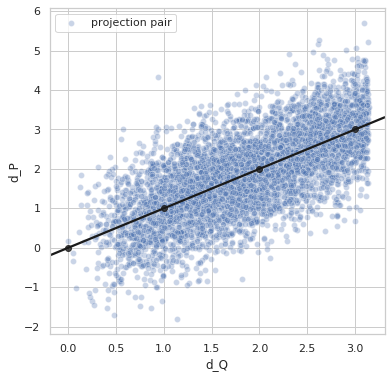

<Figure size 432x288 with 0 Axes>

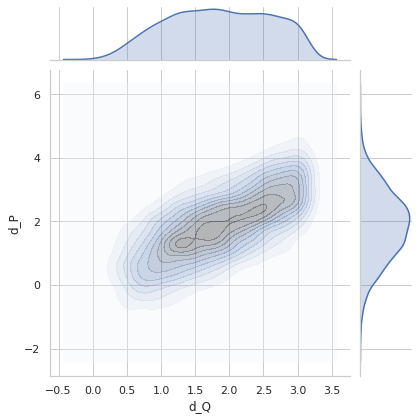

Variance = 0.7926812402144794
Min. angle recovery loss possible = 0.6282178798782476


In [16]:
plot_dP_dQ(dP_values, dQ_values);

#### Angle Recovery

In [18]:
from cryoem.angle_recovery import train_angle_recovery

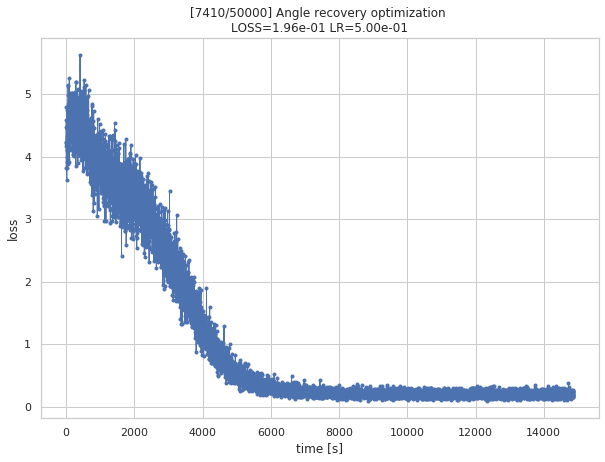

Shape of projections: (5000, 4)step 5000/50000 (10021s): loss = 2.92e-01
step 7410/50000 (14868s): loss = 2.61e-01



In [19]:
q_predicted, losses, q_all = train_angle_recovery(steps=50000, 
                             batch_size=1024, 
                             in_data=angles_true, 
                             distance_fn=d_p, 
                             learning_rate=0.5, 
                             limit_distance=0.5,
                             file_name="data/5j0n/ar_perfect_le0.5_50k")

In [29]:
data = np.load("data/5j0n/ar_perfect_le0.5_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

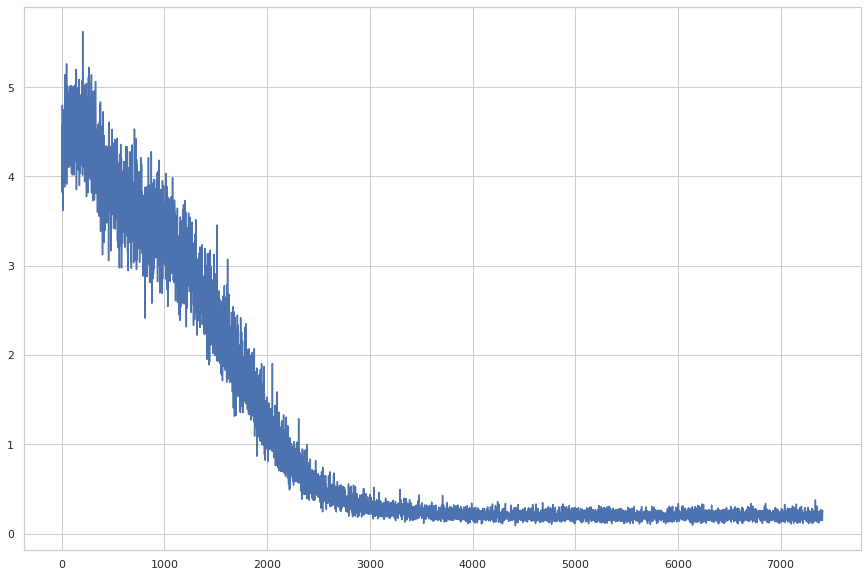

In [30]:
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(losses[losses!=0.0])
plt.show()

In [31]:
np.mean(losses[losses!=0][-10:])

0.1957556051248006

In [19]:
from cryoem.plots import plot_images

In [21]:
# plot_images(angles_predicted, projections, indices=range(100), img_size_scale=0.05)

In [ ]:
# ipv.screenshot()

In [ ]:
#np.save("data/5j0n/projections_estimated_le0.5_50k", projections)
#np.save("data/5j0n/angles_true_estimated_le0.5_50k", angles_true)

In [22]:
np.save("data/5j0n/angles_predicted_perfect_le0.5_50k", angles_predicted)

### Angle Alignment

In [24]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

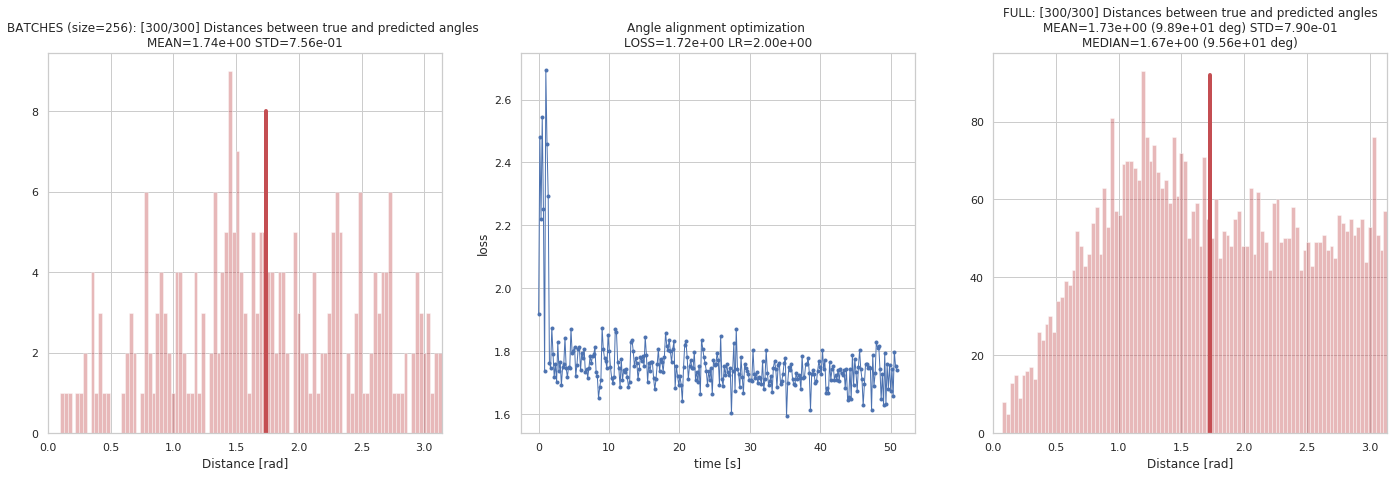

step 30/300 (5s): loss = 1.93e+00
step 60/300 (10s): loss = 1.77e+00
step 90/300 (15s): loss = 1.76e+00
step 120/300 (20s): loss = 1.76e+00
step 150/300 (25s): loss = 1.75e+00
step 180/300 (30s): loss = 1.73e+00
step 210/300 (35s): loss = 1.72e+00
step 240/300 (42s): loss = 1.73e+00
step 270/300 (47s): loss = 1.72e+00
step 300/300 (52s): loss = 1.73e+00



In [34]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=angles_true, 
                                                        angles_predicted=angles_predicted)

In [37]:
losses[-1], m

(1.5719344700885038, [1.0, 1.0, 1.0, 1.0])

In [36]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)

angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

np.save("data/5j0n/ar_perfect_rotated_le0.5_50k", angles_predicted_rotated)